# Databento MBP-1 Raw Data Investigation

This notebook downloads raw MBP-1 (Market By Price Level 1) data from Databento for OLMA on 2025-11-18
and investigates the price anomaly at 11:34:30.400 UTC.

**Symbol**: OLMA  
**Date**: 2025-11-18  
**Anomaly Time**: 11:34:30.400 UTC (Ask jumped to $21.20)  
**Purpose**: Verify if the anomaly exists in raw Databento data or was introduced during processing

In [3]:
import os
import databento as db
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

# Check for API key
api_key = os.environ.get('DATABENTO_API_KEY')
if not api_key:
    print("⚠️ DATABENTO_API_KEY not set in environment variables!")
    print("Please set it with: os.environ['DATABENTO_API_KEY'] = 'your-key-here'")
else:
    print("✅ Databento API key found")

✅ Databento API key found


## 1. Configuration

### Databento Publisher ID Mapping

According to Databento documentation, publisher IDs are venue-specific in raw data.
Our resampler maps them to standard consolidated feed IDs.

In [4]:
# Configuration
SYMBOL = 'OLMA'
DATE = '2025-11-18'
ANOMALY_TIME = datetime(2025, 11, 18, 11, 34, 30, 400000)  # UTC

# Dataset to Publisher ID mapping (from get_sessions.py)
DATASET_TO_PUBLISHER_ID = {
    'XNAS.ITCH': 1,    # NASDAQ
    'XNYS.PILLAR': 2,  # NYSE
    'ARCX.PILLAR': 3,  # NYSE Arca
    'BATS.PITCH': 4,   # Cboe BZX (formerly BATS)
    'IEXG.TOPS': 5,    # IEX
    'XBOS.ITCH': 6,    # NASDAQ BX (Boston)
    'XPSX.ITCH': 43,   # NASDAQ PSX
}

PUBLISHER_NAMES = {
    1: 'NASDAQ',
    2: 'NYSE',
    3: 'NYSE Arca',
    4: 'Cboe BZX',
    5: 'IEX',
    6: 'NASDAQ BX',
    43: 'NASDAQ PSX'
}

# All datasets to query
DATASETS = [
    'XNAS.ITCH',     # NASDAQ
    'XNYS.PILLAR',   # NYSE
    'IEXG.TOPS',     # IEX
    'ARCX.PILLAR',   # NYSE Arca
    'BATS.PITCH',    # Cboe BZX
    'XBOS.ITCH',     # NASDAQ BX
    'XPSX.ITCH',     # NASDAQ PSX
]

print(f"Symbol: {SYMBOL}")
print(f"Date: {DATE}")
print(f"Anomaly time: {ANOMALY_TIME}")
print(f"\nWill query {len(DATASETS)} datasets/exchanges")
for ds in DATASETS:
    pub_id = DATASET_TO_PUBLISHER_ID[ds]
    pub_name = PUBLISHER_NAMES[pub_id]
    print(f"  {ds:15} -> Publisher ID {pub_id:2} ({pub_name})")

Symbol: OLMA
Date: 2025-11-18
Anomaly time: 2025-11-18 11:34:30.400000

Will query 7 datasets/exchanges
  XNAS.ITCH       -> Publisher ID  1 (NASDAQ)
  XNYS.PILLAR     -> Publisher ID  2 (NYSE)
  IEXG.TOPS       -> Publisher ID  5 (IEX)
  ARCX.PILLAR     -> Publisher ID  3 (NYSE Arca)
  BATS.PITCH      -> Publisher ID  4 (Cboe BZX)
  XBOS.ITCH       -> Publisher ID  6 (NASDAQ BX)
  XPSX.ITCH       -> Publisher ID 43 (NASDAQ PSX)


## 2. Download Raw MBP-1 Data

We'll download data for a 10-second window around the anomaly time (11:34:25 to 11:34:35).

In [40]:
# Time window around anomaly (±5 seconds)
start_time = datetime(2025, 11, 18, 0, 00, 00, 400000) #ANOMALY_TIME - timedelta(seconds=5)
end_time = datetime(2025, 11, 18, 23, 30, 00, 400000) #ANOMALY_TIME + timedelta(seconds=5)

print(f"Downloading MBP-1 data from {start_time} to {end_time}")
print(f"Window: {(end_time - start_time).total_seconds()} seconds")
print()

# Initialize Databento client
client = db.Historical(api_key)

# Storage for all data
all_data = []

# Query each dataset
for i, dataset in enumerate(DATASETS, 1):
    pub_id = DATASET_TO_PUBLISHER_ID[dataset]
    pub_name = PUBLISHER_NAMES[pub_id]
    
    print(f"[{i}/{len(DATASETS)}] Querying {dataset} ({pub_name})...")
    
    try:
        data = client.timeseries.get_range(
            dataset=dataset,
            symbols=[SYMBOL],
            schema='mbp-1',
            start=start_time.isoformat(),
            end=end_time.isoformat(),
            stype_in='raw_symbol',
        )
        
        df = data.to_df()
        
        if df.empty:
            print(f"  ⚠️  No data from {dataset}")
            continue
        
        # Add exchange information
        df['dataset'] = dataset
        df['mapped_publisher_id'] = pub_id
        df['exchange_name'] = pub_name
        
        print(f"  ✅ {len(df):,} records")
        print(f"     Original publisher_id: {df['publisher_id'].unique()}")
        
        all_data.append(df)
        
    except Exception as e:
        print(f"  ❌ Error: {e}")
        continue

print(f"\n{'='*80}")
print(f"Downloaded data from {len(all_data)} exchanges")

Window: 84600.0 seconds

[1/7] Querying XNAS.ITCH (NASDAQ)...
  ✅ 703,016 records
     Original publisher_id: [2]
[2/7] Querying XNYS.PILLAR (NYSE)...
  ✅ 176,517 records
     Original publisher_id: [9]
[3/7] Querying IEXG.TOPS (IEX)...
  ✅ 364,218 records
     Original publisher_id: [38]
[4/7] Querying ARCX.PILLAR (NYSE Arca)...
  ✅ 949,572 records
     Original publisher_id: [43]
[5/7] Querying BATS.PITCH (Cboe BZX)...
  ✅ 471,003 records
     Original publisher_id: [5]
[6/7] Querying XBOS.ITCH (NASDAQ BX)...
  ✅ 70,269 records
     Original publisher_id: [3]
[7/7] Querying XPSX.ITCH (NASDAQ PSX)...
  ✅ 116,016 records
     Original publisher_id: [4]

Downloaded data from 7 exchanges


## 3. Combine and Process Data

In [42]:
if not all_data:
    print("❌ No data retrieved! Check if OLMA was trading on this date and if you have access to the datasets.")
else:
    # Combine all data
    df_combined = pd.concat(all_data, ignore_index=True)
    
    # Sort by timestamp
    df_combined = df_combined.sort_values('ts_event').reset_index(drop=True)
    
    # Convert timestamp to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(df_combined['ts_event']):
        df_combined['ts_event'] = pd.to_datetime(df_combined['ts_event'], utc=True)
    
    # Calculate bid-ask prices (prices are in fixed-point, need to divide by 1e9 for actual price)
    # Note: Databento uses fixed-point integer representation
    df_combined['bid_price'] = df_combined['bid_px_00']# / 1e8
    df_combined['ask_price'] = df_combined['ask_px_00']# / 1e8
    df_combined['bid_size'] = df_combined['bid_sz_00']
    df_combined['ask_size'] = df_combined['ask_sz_00']
    df_combined['spread'] = df_combined['ask_price'] - df_combined['bid_price']
    df_combined['mid_price'] = (df_combined['bid_price'] + df_combined['ask_price']) / 2
    
    print(f"Total records: {len(df_combined):,}")
    print(f"Time range: {df_combined['ts_event'].min()} to {df_combined['ts_event'].max()}")
    print(f"Exchanges: {df_combined['exchange_name'].nunique()}")
    print()
    print("Records per exchange:")
    print(df_combined.groupby('exchange_name').size().sort_values(ascending=False))
    print()
    print("First few records:")
df_combined[['ts_event', 'exchange_name', 'mapped_publisher_id', 'bid_price', 'ask_price', 'mid_price', 'spread', 'bid_size', 'ask_size']]

Total records: 2,850,611
Time range: 2025-11-18 05:28:24.499438934+00:00 to 2025-11-18 23:29:57.364560601+00:00
Exchanges: 7

Records per exchange:
exchange_name
NYSE Arca     949572
NASDAQ        703016
Cboe BZX      471003
IEX           364218
NYSE          176517
NASDAQ PSX    116016
NASDAQ BX      70269
dtype: int64

First few records:


,ts_event,exchange_name,mapped_publisher_id,bid_price,ask_price,mid_price,spread,bid_size,ask_size
0,2025-11-18 05:28:24.499438934+00:00,NYSE,2,NaN,NaN,NaN,NaN,0,0
1,2025-11-18 05:37:08.362312881+00:00,NYSE Arca,3,NaN,NaN,NaN,NaN,0,0
2,2025-11-18 09:00:00.029646462+00:00,NYSE Arca,3,7.83,NaN,NaN,NaN,100,0
3,2025-11-18 09:00:00.069526845+00:00,NYSE Arca,3,7.83,8.95,8.390,1.12,100,100
4,2025-11-18 09:00:14.951926712+00:00,NYSE Arca,3,7.83,8.86,8.345,1.03,100,20
...,...,...,...,...,...,...,...,...,...
2850606,2025-11-18 23:29:54.520926161+00:00,NASDAQ,1,19.28,19.76,19.520,0.48,71,100
2850607,2025-11-18 23:29:54.520971472+00:00,NASDAQ,1,19.26,19.76,19.510,0.50,29,100
2850608,2025-11-18 23:29:54.755319+00:00,Cboe BZX,4,18.40,19.85,19.125,1.45,150,670
2850609,2025-11-18 23:29:55.505003526+00:00,NASDAQ,1,19.22,19.76,19.490,0.54,4,100


## 4. Focus on Anomaly Time Window

Let's examine the data around 11:34:30.400 (±500ms)

In [18]:
from datetime import datetime, timedelta, timezone
ANOMALY_TIME = datetime(2025, 11, 18, 11, 34, 30, 400000, tzinfo=timezone.utc)

In [19]:
if not all_data:
    print("No data to analyze")
else:
    # Focus on ±500ms around anomaly
    window_start = ANOMALY_TIME - timedelta(milliseconds=500)
    window_end = ANOMALY_TIME + timedelta(milliseconds=500)
    
    df_anomaly = df_combined[
        (df_combined['ts_event'] >= window_start) & 
        (df_combined['ts_event'] <= window_end)
    ].copy()
    
    print(f"Anomaly window: {window_start} to {window_end}")
    print(f"Records in window: {len(df_anomaly)}")
    print()
    
    if len(df_anomaly) > 0:
        # Show all records in chronological order
        print("=" * 120)
        print("ALL QUOTES AROUND ANOMALY TIME")
        print("=" * 120)
        
        for idx, row in df_anomaly.iterrows():
            ts_str = row['ts_event'].strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
            print(f"\n{ts_str} | {row['exchange_name']:12} (pub_id={row['mapped_publisher_id']:2})")
            print(f"  Bid: ${row['bid_price']:.5f} (size={row['bid_size']:>6}) | Ask: ${row['ask_price']:.5f} (size={row['ask_size']:>6})")
            print(f"  Mid: ${row['mid_price']:.5f} | Spread: ${row['spread']:.5f}")
            
            # Highlight abnormal spreads
            if row['spread'] > 1.0:
                print(f"  ⚠️  WIDE SPREAD: ${row['spread']:.5f}")
            if row['ask_price'] > 20:
                print(f"  🔴 ABNORMAL ASK PRICE: ${row['ask_price']:.5f}")
    else:
        print("⚠️ No data in anomaly window!")

Anomaly window: 2025-11-18 11:34:29.900000+00:00 to 2025-11-18 11:34:30.900000+00:00
Records in window: 24

ALL QUOTES AROUND ANOMALY TIME

2025-11-18 11:34:30.536 | NYSE Arca    (pub_id= 3)
  Bid: $14.46000 (size=   111) | Ask: $14.48000 (size=   300)
  Mid: $14.47000 | Spread: $0.02000

2025-11-18 11:34:30.634 | NASDAQ       (pub_id= 1)
  Bid: $14.46000 (size=   300) | Ask: $14.50000 (size=   116)
  Mid: $14.48000 | Spread: $0.04000

2025-11-18 11:34:30.634 | NASDAQ       (pub_id= 1)
  Bid: $14.46000 (size=   300) | Ask: $14.47000 (size=    20)
  Mid: $14.46500 | Spread: $0.01000

2025-11-18 11:34:30.635 | NASDAQ       (pub_id= 1)
  Bid: $14.47000 (size=    20) | Ask: $14.50000 (size=   116)
  Mid: $14.48500 | Spread: $0.03000

2025-11-18 11:34:30.638 | NASDAQ       (pub_id= 1)
  Bid: $14.47000 (size=   420) | Ask: $14.50000 (size=   116)
  Mid: $14.48500 | Spread: $0.03000

2025-11-18 11:34:30.639 | NYSE Arca    (pub_id= 3)
  Bid: $14.46000 (size=   111) | Ask: $14.48000 (size=   30

## 5. Check Cboe BZX Specifically

Since we identified Cboe BZX as the source of the anomaly, let's examine all their quotes.

In [20]:
if not all_data:
    print("No data to analyze")
else:
    # Filter for Cboe BZX (Publisher ID 4)
    df_bzx = df_combined[df_combined['mapped_publisher_id'] == 4].copy()
    
    print(f"Cboe BZX (BATS.PITCH) records: {len(df_bzx)}")
    print()
    
    if len(df_bzx) > 0:
        print("All Cboe BZX quotes in the 10-second window:")
        print("=" * 120)
        
        for idx, row in df_bzx.iterrows():
            ts_str = row['ts_event'].strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
            print(f"\n{ts_str}")
            print(f"  Bid: ${row['bid_price']:.5f} (size={row['bid_size']:>6}) | Ask: ${row['ask_price']:.5f} (size={row['ask_size']:>6})")
            print(f"  Mid: ${row['mid_price']:.5f} | Spread: ${row['spread']:.5f}")
            
            # Highlight the anomaly
            if row['ask_price'] > 20:
                print(f"  🔴 THIS IS THE ANOMALY! Ask jumped to ${row['ask_price']:.5f}")
            if row['spread'] > 1.0:
                print(f"  ⚠️  Wide spread: ${row['spread']:.5f}")
        
        print("\n" + "=" * 120)
        print("\nCboe BZX Statistics:")
        print(f"  Mean spread: ${df_bzx['spread'].mean():.5f}")
        print(f"  Median spread: ${df_bzx['spread'].median():.5f}")
        print(f"  Max spread: ${df_bzx['spread'].max():.5f}")
        print(f"  Min ask: ${df_bzx['ask_price'].min():.5f}")
        print(f"  Max ask: ${df_bzx['ask_price'].max():.5f}")
    else:
        print("⚠️ No Cboe BZX data found!")

Cboe BZX (BATS.PITCH) records: 1

All Cboe BZX quotes in the 10-second window:

2025-11-18 11:34:31.050
  Bid: $14.46000 (size=     2) | Ask: $14.58000 (size=    15)
  Mid: $14.52000 | Spread: $0.12000


Cboe BZX Statistics:
  Mean spread: $0.12000
  Median spread: $0.12000
  Max spread: $0.12000
  Min ask: $14.58000
  Max ask: $14.58000


## 6. Visualize the Data

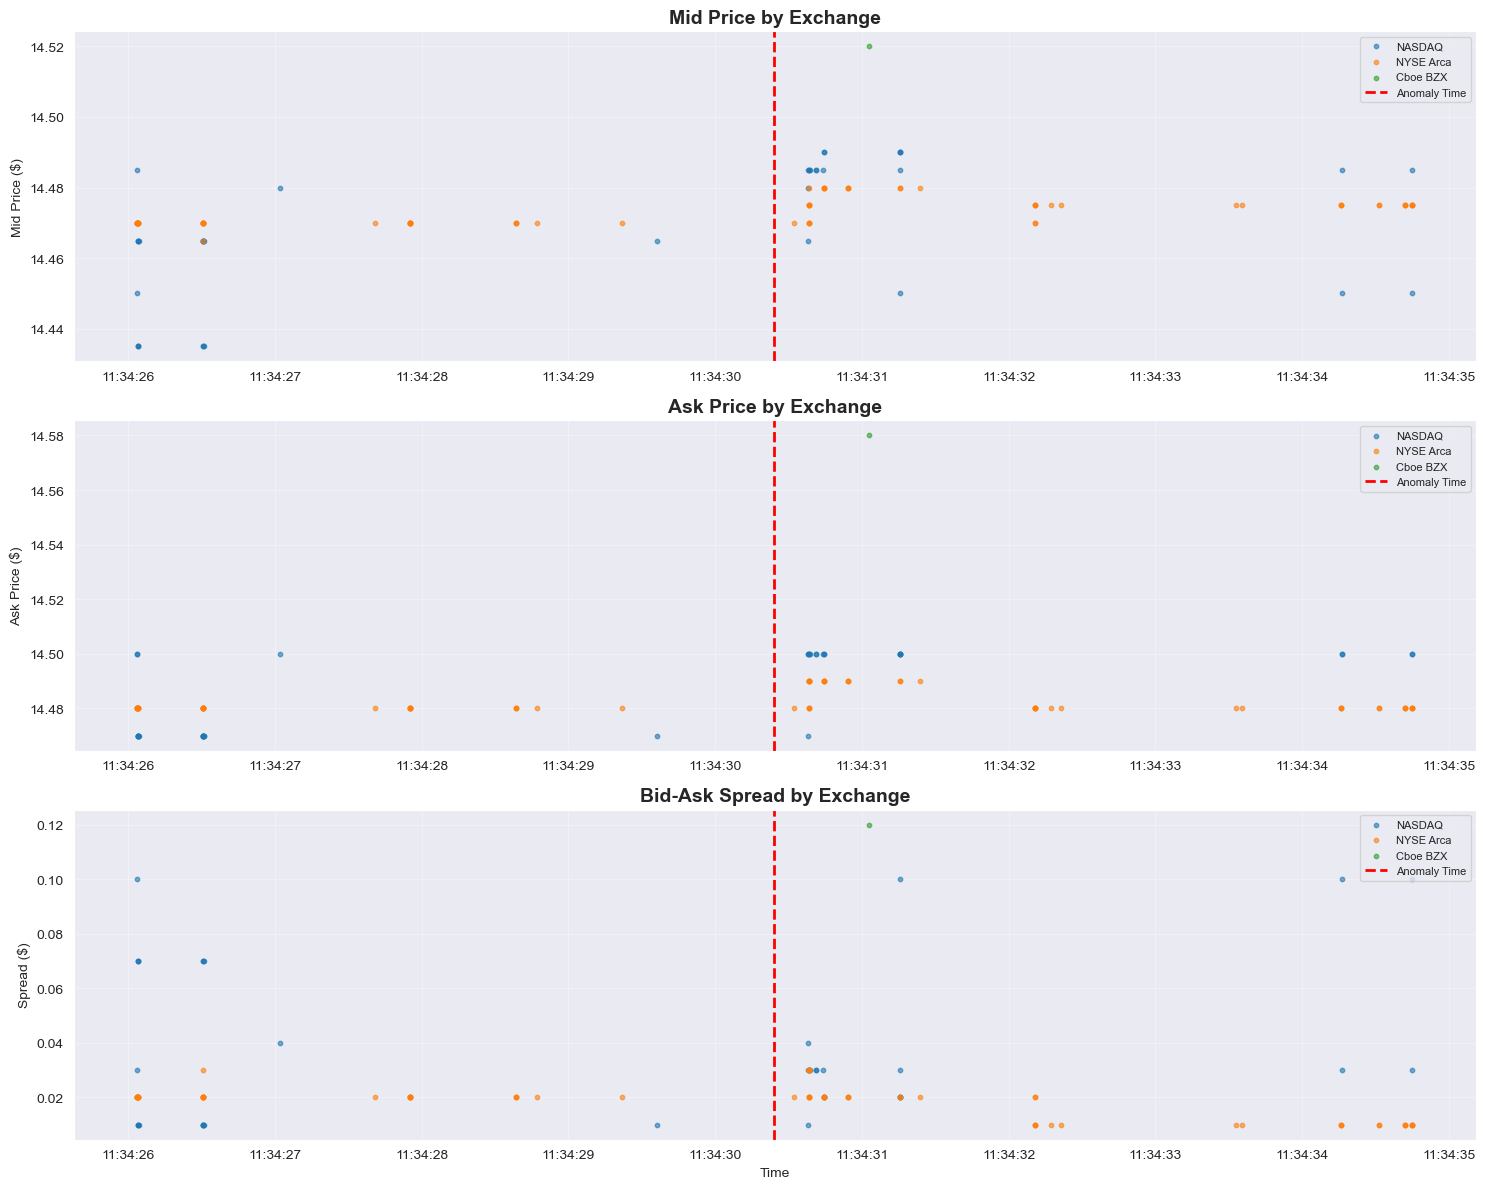

In [21]:
if not all_data:
    print("No data to visualize")
else:
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: All mid prices by exchange
    for exchange in df_combined['exchange_name'].unique():
        df_ex = df_combined[df_combined['exchange_name'] == exchange]
        axes[0].scatter(df_ex['ts_event'], df_ex['mid_price'], label=exchange, alpha=0.6, s=10)
    
    axes[0].axvline(x=ANOMALY_TIME, color='red', linestyle='--', linewidth=2, label='Anomaly Time')
    axes[0].set_title('Mid Price by Exchange', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Mid Price ($)')
    axes[0].legend(loc='upper right', fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Ask prices (to see the spike)
    for exchange in df_combined['exchange_name'].unique():
        df_ex = df_combined[df_combined['exchange_name'] == exchange]
        axes[1].scatter(df_ex['ts_event'], df_ex['ask_price'], label=exchange, alpha=0.6, s=10)
    
    axes[1].axvline(x=ANOMALY_TIME, color='red', linestyle='--', linewidth=2, label='Anomaly Time')
    axes[1].set_title('Ask Price by Exchange', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Ask Price ($)')
    axes[1].legend(loc='upper right', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Spreads
    for exchange in df_combined['exchange_name'].unique():
        df_ex = df_combined[df_combined['exchange_name'] == exchange]
        axes[2].scatter(df_ex['ts_event'], df_ex['spread'], label=exchange, alpha=0.6, s=10)
    
    axes[2].axvline(x=ANOMALY_TIME, color='red', linestyle='--', linewidth=2, label='Anomaly Time')
    axes[2].set_title('Bid-Ask Spread by Exchange', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Spread ($)')
    axes[2].legend(loc='upper right', fontsize=8)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Calculate NBBO from Raw Data

Let's calculate what the NBBO should be at the anomaly time by taking the best bid and best ask across all exchanges.

In [25]:
if not all_data:
    print("No data to analyze")
else:
    # Group by time bins (100ms to match resampling interval)
    df_combined['time_bin'] = df_combined['ts_event'].dt.floor('100ms')
    
    # For each time bin, find best bid (highest) and best ask (lowest)
    def calculate_nbbo(group):
        # Filter out invalid prices
        valid_quotes = group[(group['bid_price'] > 0) & (group['ask_price'] > 0)]
        
        if len(valid_quotes) == 0:
            return pd.Series({
                'nbbo_bid': np.nan,
                'nbbo_ask': np.nan,
                'nbbo_mid': np.nan,
                'nbbo_spread': np.nan,
                'nbbo_bid_exchange': None,
                'nbbo_ask_exchange': None,
                'num_exchanges': 0
            })
        
        # Best bid (highest)
        best_bid_idx = valid_quotes['bid_price'].idxmax()
        best_bid = valid_quotes.loc[best_bid_idx, 'bid_price']
        best_bid_exchange = valid_quotes.loc[best_bid_idx, 'exchange_name']
        
        # Best ask (lowest)
        best_ask_idx = valid_quotes['ask_price'].idxmin()
        best_ask = valid_quotes.loc[best_ask_idx, 'ask_price']
        best_ask_exchange = valid_quotes.loc[best_ask_idx, 'exchange_name']
        
        return pd.Series({
            'nbbo_bid': best_bid,
            'nbbo_ask': best_ask,
            'nbbo_mid': (best_bid + best_ask) / 2,
            'nbbo_spread': best_ask - best_bid,
            'nbbo_bid_exchange': best_bid_exchange,
            'nbbo_ask_exchange': best_ask_exchange,
            'num_exchanges': len(valid_quotes['exchange_name'].unique())
        })
    
    nbbo = df_combined.groupby('time_bin').apply(calculate_nbbo, include_groups=False).reset_index()
    
    print("NBBO Calculation (100ms bins):")
    print("=" * 120)
    print()
    
    # Focus on anomaly window
    anomaly_bin = pd.Timestamp(ANOMALY_TIME).floor('100ms')
    nbbo_anomaly = nbbo[
        (nbbo['time_bin'] >= anomaly_bin - timedelta(milliseconds=1000)) &
        (nbbo['time_bin'] <= anomaly_bin + timedelta(milliseconds=500))
    ]
    
    for idx, row in nbbo_anomaly.iterrows():
        ts_str = row['time_bin'].strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
        print(f"\n{ts_str}")
        print(f"  NBBO Bid: ${row['nbbo_bid']:.5f} from {row['nbbo_bid_exchange']}")
        print(f"  NBBO Ask: ${row['nbbo_ask']:.5f} from {row['nbbo_ask_exchange']}")
        print(f"  NBBO Mid: ${row['nbbo_mid']:.5f}")
        print(f"  Spread: ${row['nbbo_spread']:.5f}")
        print(f"  Exchanges: {row['num_exchanges']}")
        
        if row['nbbo_spread'] > 1.0:
            print(f"  ⚠️  WIDE SPREAD DETECTED!")
        if row['nbbo_ask'] > 20:
            print(f"  🔴 ABNORMAL ASK IN NBBO!")

NBBO Calculation (100ms bins):


2025-11-18 11:34:29.600
  NBBO Bid: $14.46000 from NASDAQ
  NBBO Ask: $14.47000 from NASDAQ
  NBBO Mid: $14.46500
  Spread: $0.01000
  Exchanges: 1

2025-11-18 11:34:30.500
  NBBO Bid: $14.46000 from NYSE Arca
  NBBO Ask: $14.48000 from NYSE Arca
  NBBO Mid: $14.47000
  Spread: $0.02000
  Exchanges: 1

2025-11-18 11:34:30.600
  NBBO Bid: $14.47000 from NASDAQ
  NBBO Ask: $14.47000 from NASDAQ
  NBBO Mid: $14.47000
  Spread: $0.00000
  Exchanges: 2

2025-11-18 11:34:30.700
  NBBO Bid: $14.48000 from NASDAQ
  NBBO Ask: $14.49000 from NYSE Arca
  NBBO Mid: $14.48500
  Spread: $0.01000
  Exchanges: 2

2025-11-18 11:34:30.900
  NBBO Bid: $14.47000 from NYSE Arca
  NBBO Ask: $14.49000 from NYSE Arca
  NBBO Mid: $14.48000
  Spread: $0.02000
  Exchanges: 1


In [26]:
nbbo_anomaly

,time_bin,nbbo_bid,nbbo_ask,nbbo_mid,nbbo_spread,nbbo_bid_exchange,nbbo_ask_exchange,num_exchanges
8,2025-11-18 11:34:29.600000+00:00,14.46,14.47,14.465,0.01,NASDAQ,NASDAQ,1
9,2025-11-18 11:34:30.500000+00:00,14.46,14.48,14.470,0.02,NYSE Arca,NYSE Arca,1
10,2025-11-18 11:34:30.600000+00:00,14.47,14.47,14.470,0.00,NASDAQ,NASDAQ,2
11,2025-11-18 11:34:30.700000+00:00,14.48,14.49,14.485,0.01,NASDAQ,NYSE Arca,2
12,2025-11-18 11:34:30.900000+00:00,14.47,14.49,14.480,0.02,NYSE Arca,NYSE Arca,1


## 8. Summary and Conclusions

In [27]:
if not all_data:
    print("No data to summarize")
else:
    print("=" * 120)
    print("SUMMARY")
    print("=" * 120)
    print()
    print("1. Data Source: Raw MBP-1 data from Databento API")
    print(f"2. Total records downloaded: {len(df_combined):,}")
    print(f"3. Exchanges with data: {df_combined['exchange_name'].nunique()}")
    print()
    
    # Check if anomaly exists in raw data
    abnormal_asks = df_combined[df_combined['ask_price'] > 20]
    if len(abnormal_asks) > 0:
        print("4. ✅ ANOMALY CONFIRMED IN RAW DATA:")
        for idx, row in abnormal_asks.iterrows():
            ts_str = row['ts_event'].strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
            print(f"   - {ts_str}: {row['exchange_name']} had ask at ${row['ask_price']:.5f}")
        print()
        print("   This confirms the anomaly is in the original market data,")
        print("   NOT introduced during processing.")
    else:
        print("4. ⚠️ No abnormal asks found in raw data")
        print("   The anomaly may have been during a different time period.")
    
    print()
    print("5. Publisher ID Mapping Verification:")
    for dataset, pub_id in DATASET_TO_PUBLISHER_ID.items():
        df_ds = df_combined[df_combined['dataset'] == dataset]
        if len(df_ds) > 0:
            original_pub_id = df_ds['publisher_id'].iloc[0]
            print(f"   {dataset:15} - Original pub_id: {original_pub_id:3} -> Mapped to: {pub_id:2} ({PUBLISHER_NAMES[pub_id]})")
    
    print()
    print("6. Recommendation:")
    print("   - Implement spread filtering before NBBO calculation")
    print("   - Filter out quotes with spreads > $1.00 or > 10x median spread")
    print("   - Consider time-based filtering for market open/close anomalies")

SUMMARY

1. Data Source: Raw MBP-1 data from Databento API
2. Total records downloaded: 112
3. Exchanges with data: 3

4. ⚠️ No abnormal asks found in raw data
   The anomaly may have been during a different time period.

5. Publisher ID Mapping Verification:
   XNAS.ITCH       - Original pub_id:   2 -> Mapped to:  1 (NASDAQ)
   ARCX.PILLAR     - Original pub_id:  43 -> Mapped to:  3 (NYSE Arca)
   BATS.PITCH      - Original pub_id:   5 -> Mapped to:  4 (Cboe BZX)

6. Recommendation:
   - Implement spread filtering before NBBO calculation
   - Filter out quotes with spreads > $1.00 or > 10x median spread
   - Consider time-based filtering for market open/close anomalies


In [51]:
# get ask at 21.20
df_combined[df_combined['ask_price'] > 21.15].head(41)

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,symbol,dataset,mapped_publisher_id,exchange_name,bid_price,ask_price,bid_size,ask_size,spread,mid_price
43818,2025-11-18 10:34:19.108270+00:00,1,5,11950,C,A,0,12.69,100,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.48,21.20,100,84,8.72,16.840
43820,2025-11-18 10:34:19.108325+00:00,1,5,11950,A,B,0,12.52,1,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.52,21.20,1,84,8.68,16.860
43824,2025-11-18 10:34:19.108349+00:00,1,5,11950,A,B,0,12.52,8,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.52,21.20,12,84,8.68,16.860
43825,2025-11-18 10:34:19.108387+00:00,1,5,11950,A,B,0,12.58,8,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.58,21.20,8,84,8.62,16.890
43828,2025-11-18 10:34:19.109402+00:00,1,5,11950,C,B,0,12.58,8,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.52,21.20,10,84,8.68,16.860
43845,2025-11-18 10:34:19.120566+00:00,1,5,11950,A,B,0,12.68,3,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.68,21.20,3,84,8.52,16.940
43846,2025-11-18 10:34:19.120584+00:00,1,5,11950,A,B,0,12.68,8,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.68,21.20,11,84,8.52,16.940
43847,2025-11-18 10:34:19.120596+00:00,1,5,11950,A,B,0,12.68,8,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.68,21.20,19,84,8.52,16.940
43848,2025-11-18 10:34:19.120631+00:00,1,5,11950,A,B,0,12.69,1,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.69,21.20,1,84,8.51,16.945
43851,2025-11-18 10:34:19.120655+00:00,1,5,11950,A,B,0,12.69,8,128,...,OLMA,BATS.PITCH,4,Cboe BZX,12.69,21.20,12,84,8.51,16.945


In [38]:
df_combined.columns

Index(['ts_event', 'rtype', 'publisher_id', 'instrument_id', 'action', 'side',
       'depth', 'price', 'size', 'flags', 'ts_in_delta', 'sequence',
       'bid_px_00', 'ask_px_00', 'bid_sz_00', 'ask_sz_00', 'bid_ct_00',
       'ask_ct_00', 'symbol', 'dataset', 'mapped_publisher_id',
       'exchange_name', 'bid_price', 'ask_price', 'bid_size', 'ask_size',
       'spread', 'mid_price', 'time_bin'],
      dtype='object')